<a href="https://colab.research.google.com/github/Quarieda/30-Days-Of-Python/blob/master/Diabetes_%7C_XGB_HGB_LGBM_CatB_Ensemble_%7C_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e12_path = kagglehub.competition_download('playground-series-s5e12')

print('Data source import complete.')


# Overview and main features

**1. Import packages**

**2. Load and explore data:**
* Load and split data into train and validation sets in a stratified manner. As reference for the stratification either a calculated multilabel (based on selected features and/or labels) or simply the label can be used (*EXTENDED_STRAT == False*).
* List of dataset columns including data types and number of non-zero elements.
* Show number of unique elements of categorical features.
* Show probability distribution of numerical and logarithmic features.

**3. Preprocess data:**
* The dataset includes three main types of data: numerical features with normal distribution, logarithmic features with normal distribution and categorical features.
* Preprocessing pipeline includes an imputing step (for robustness of pipeline, currently there are no missing values in raw data), a transforming step (for logarithmic and categorical features) and a scaling step (for logarithmic and numerical features).

**4. Define model space for ML methods:**
* Definition of model space with a large number of possible ML methods:
    * Linear models: SGD
    * Support vector machine model: SVC
    * Ensemble models: RandomForest / GradientBoosting / AdaBoost / HistGradientBoosting / XGB / LGBM / CatBoost
    * Other models: KNeighbors

**5. Training and evaluation:**
* Definition of model parameters for single fitting and tuner interfaces.
* Simple fitting or tuning (*TUNING_ML == True*) choosen models (est_ids) on whole dataset.
* PCA can be added into the pipeline to reduce number of features (*PCA_active == True*).
* Refit models only on train set for validation purposes.
* Calculate ROC AUC score for all estimators on both train and validation dataset.
* ROC AUC score on mean value of ensemble predictions on validation dataset.
* Show feature importances.

**6. Submission:**
* Predict labels and create submission.csv file.
* If more than 1 model have been choosen in est_ids (Ensemble solution) then the prediction will be an average of the predictions of the single models.

# 1. Import packages

In [ ]:
## Import packages

# General purpose modules
import time
from copy import deepcopy

# Data handling and visualization modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Skikit-learn preprocessing and evaluation modules
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

# Skikit-learn ML modules
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# Further ML modules
import xgboost as xgboost
import lightgbm as lightgbm
from catboost import CatBoostClassifier

# 2. Load and explore data

In [ ]:
## Read csv files

trainval = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')

## Spliting the train data into train, val and tes

EXTENDED_STRAT = True # Stratification is based on multiple columns

strat_cols = ['family_history_diabetes', 'cardiovascular_history','ethnicity', 'diagnosed_diabetes']
trainval['multicat'] = LabelEncoder().fit_transform(trainval[strat_cols].astype(str).agg('_'.join, axis=1))
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
if EXTENDED_STRAT:
    train_idx, val_idx = next(sss.split(trainval, trainval['multicat']))
else:
    train_idx, val_idx = next(sss.split(trainval, trainval['diagnosed_diabetes']))
train = trainval.iloc[train_idx].reset_index()
val = trainval.iloc[val_idx].reset_index()
trainval_labels = trainval.pop('diagnosed_diabetes')
train_labels = train.pop('diagnosed_diabetes')
val_labels = val.pop('diagnosed_diabetes')

# Verify sizes
print(f"Total rows:   {len(trainval)}")
print(f"Dev train:    {len(train)} ({len(train)/len(trainval):.2%})")
print(f"Dev valid:    {len(val)} ({len(val)/len(trainval):.2%})")
print(f"Number of unique elements in multicat column: {len(trainval['multicat'].unique())}")

Total rows:   700000
Dev train:    560000 (80.00%)
Dev valid:    140000 (20.00%)
Number of unique elements in multicat column: 40


List of dataset columns including data types and number of non-zero elements: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 27 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   index                               560000 non-null  int64  
 1   id                                  560000 non-null  int64  
 2   age                                 560000 non-null  int64  
 3   alcohol_consumption_per_week        560000 non-null  int64  
 4   physical_activity_minutes_per_week  560000 non-null  int64  
 5   diet_score                          560000 non-null  float64
 6   sleep_hours_per_day                 560000 non-null  float64
 7   screen_time_hours_per_day           560000 non-null  float64
 8   bmi                                 560000 non-null  float64
 9   waist_to_hip_ratio                  560000 non-null  float64
 10  systolic_bp 

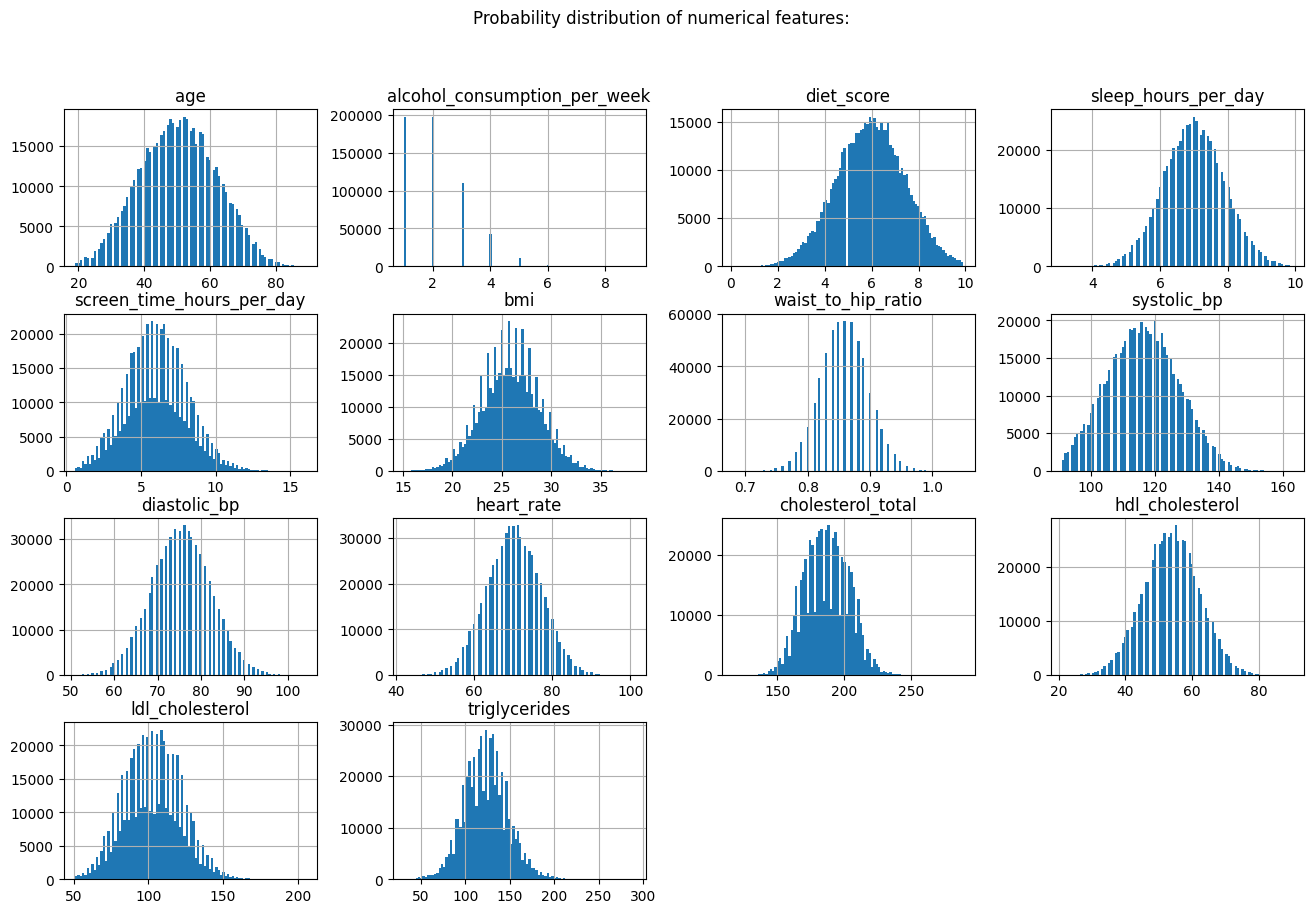

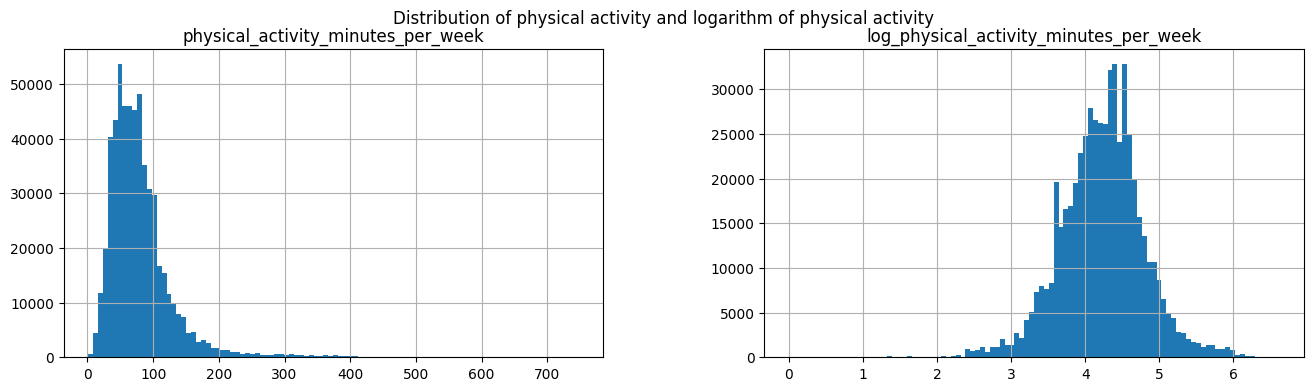

In [ ]:
## Explore train dataset

print('List of dataset columns including data types and number of non-zero elements: ', end='\n\n')
train.info()
print('-'*80, end='\n\n')

# Explore categorical features
cat_columns = make_column_selector(dtype_include='object')(train)
cat_columns.extend(['family_history_diabetes', 'hypertension_history', 'cardiovascular_history'])
print('Number of unique elements of categorical features: ', end='\n\n')
for cat in cat_columns:
    print(train[cat].value_counts(), end='\n\n')

# Explore numerical features
num_columns = make_column_selector(dtype_exclude='object')(train)
for col in ['index', 'id', 'physical_activity_minutes_per_week', 'family_history_diabetes',
            'hypertension_history', 'cardiovascular_history', 'multicat']:
    num_columns.remove(col)
train[num_columns].hist(bins=100, figsize=(16,10))
plt.suptitle('Probability distribution of numerical features: ')

# Explore logaritmical features
log_columns = ['physical_activity_minutes_per_week']
pd.concat([train[log_columns], np.log(train[log_columns]).rename(columns={
    'physical_activity_minutes_per_week' : 'log_physical_activity_minutes_per_week'})],
          axis=1).hist(bins=100, figsize=(16,4))
plt.suptitle('Distribution of physical activity and logarithm of physical activity')
print('-'*80, end='\n\n')

# 3. Preprocess data

In [ ]:
## Define and fit preprocessing pipeline

num_columns.remove('alcohol_consumption_per_week')
minmax_columns = ['alcohol_consumption_per_week']

stdscale_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                              ('std_scaling', StandardScaler())])
minmaxscale_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                                 ('minmax_scaling', MinMaxScaler())])
log_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('log_trans', FunctionTransformer(func=np.log, feature_names_out='one-to-one')),
                         ('std_scaler', StandardScaler())])
onehot_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                            ('onehot', OneHotEncoder())])

# Preprocessing pipeline
preprocessing = ColumnTransformer([("std_scaling", stdscale_pipeline, num_columns),
                                   ("minmax_scaling", minmaxscale_pipeline, minmax_columns),
                                   ("logstd_scaling", log_pipeline, log_columns),
                                  ("onehot", onehot_pipeline, cat_columns)])

# Preprocess data
trainval_prepared = preprocessing.fit_transform(trainval)
train_prepared = preprocessing.transform(train)
val_prepared = preprocessing.transform(val)

# 4. Define model space for ML methods

In [ ]:
## Helping function to create parameter grids

def make_param(param_dict, model):
    for elem in param_dict.copy():
        if elem == 'n_components':
            param_dict['pca'+'__'+elem] = param_dict.pop(elem)
        else:
            param_dict[model+'__'+elem] = param_dict.pop(elem)
    return param_dict

In [ ]:
## Machine learning models and their hyperparameter search space

# Models
svc = SVC(kernel='linear', class_weight='balanced')
rfc = RandomForestClassifier(random_state=42)
kneigh = KNeighborsClassifier()
gbc = GradientBoostingClassifier(random_state=42)
xgb = xgboost.XGBClassifier(objective='binary:logistic', class_weight='balanced', seed=0, device='cpu')
ada = AdaBoostClassifier(random_state=42)
hgbc = HistGradientBoostingClassifier(scoring='roc_auc', class_weight='balanced', random_state=42)
lgbm = lightgbm.LGBMClassifier(is_unbalance=True, random_state=42, device ='cpu', verbosity=-1)
catc = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, task_type='CPU', verbose=False)
sgdc = SGDClassifier(loss='log_loss', class_weight='balanced', random_state=42)

# Model space
EstimatorStr = {1: 'svc', 2: 'rfc', 3: 'kneigh', 4: 'gbc', 5: 'xgb', 6: 'ada', 7: 'hgbc', 8: 'lgbm', 9: 'catc', 10: 'sgdc'}
EstimatorMdl = {1: svc, 2: rfc, 3: kneigh, 4: gbc, 5: xgb, 6: ada, 7: hgbc, 8: lgbm, 9: catc, 10: sgdc}

In [ ]:
## Training parameters

# Tuned hyperparameter sets
# svc parameter
param_single_svc = make_param({#'C': 107, 'gamma': 0.00082, 'kernel': 'rbf', #'n_components': 300,
                               }, 'svc') #
# rfc parameter
param_single_rfc = make_param({#'n_estimators': 400, 'max_depth': 12, 'max_leaf_nodes': 100, 'min_samples_split': 3,
                               }, 'randomforestclassifier') # 1.0/0.6923
# kneight parameter
param_single_kneigh = make_param({#'n_estimators': 400, 'max_depth': 12, 'max_leaf_nodes': 100, 'min_samples_split': 3,
                                  }, 'kneighborsclassifier') # 0.8010/0.5936
# gbc parameter
param_single_gbc = make_param({#'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'loss': 'huber', 'min_samples_split': 3,
                              }, 'gradientboostingclassifier') # 0.7083/0.7072
# xgb parameter
param_single_xgb = make_param({'n_estimators': 140, 'tree_method': 'hist', 'max_depth': 3, 'reg_lambda': 0.25, 'learning_rate': 0.6,
                              }, 'xgbclassifier') # 0.7304/0.7230/0.6941
# ada parameter
param_single_ada = make_param({#'estimator': DecisionTreeRegressor(max_depth=180, criterion='squared_error', max_leaf_nodes=150, min_samples_split=4),
                               #'n_estimators': 300, 'learning_rate': 0.75, 'loss': 'square',
                               }, 'adaboostclassifier') # 0.7010/0.7013
# hgbc parameter
param_single_hgbc = make_param({'max_depth':3, 'learning_rate': 0.7,
                                }, 'histgradientboostingclassifier') # 0.7274/0.7241/0.6941
# lgbm parameter
param_single_lgbm = make_param({'num_leaves': 130, 'max_depth': 33,
                                }, 'lgbmclassifier') # 0.7478/0.7258/0.6954
# catc parameter
param_single_catc = make_param({#'learning_rate': 0.06, 'depth': 2, 'l2_leaf_reg': 0.3
                                }, 'catboostclassifier') # 0.7508/0.7262
# sgdc parameter
param_single_sgdc = make_param({#'learning_rate': 0.06, 'depth': 2, 'l2_leaf_reg': 0.3
                                }, 'sgdclassifier') # 0.6932/0.6935

In [ ]:
## Hyperparameter sets for parameter tuning

# xgb parameter
param_grid_xgb = make_param({'n_estimators': [100, 120, 140],
                             'tree_method': ['hist'],
                             'max_depth': [3, 4, 5, 6, 7],
                             'reg_lambda': [0.1, 0.2, 0.25, 0.3, 0.4],
                             'learning_rate': [0.4, 0.5, 0.6, 0.7, 0.8],
                             }, 'xgbclassifier')
# hgbc parameter
param_grid_hgbc = make_param({'max_depth': [3, 4, 5, 6, 9, 12],
                              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                              'class_weight': ['balanced', None],
                                }, 'histgradientboostingclassifier')
# lgbm parameter
param_grid_lgbm = make_param({'num_leaves': [80,110,120,125,130,135,140,150,180],
                              'max_depth': [24,29,31,32,33,35,40],
                              'is_unbalance': [False, True],
                              #'learning_rate': 0.1,
                              #'n_estimators': 200,
                              }, 'lgbmclassifier')
# catc parameter
param_grid_catc = make_param({#'learning_rate': 0.06, 'depth': 2, 'l2_leaf_reg': 0.3
                                }, 'catboostclassifier')

# 5. Training and evaluation

In [ ]:
## Single fitting with tuned parameters or grid search for machine learning methods

TUNING_ML = False # Choose between single fitting or parameter tuning
PCA_active = False # Activate PCA
est_ids = [5,7,8,9] # Choose model(s) to tune {1: 'svc', 2: 'rfc', 3: 'kneigh', 4: 'gbc', 5: 'xgb', 6: 'ada', 7: 'hgbc', 8: 'lgbm', 9: 'cat', 10: 'sgdc'}

for est_id in est_ids:
    start_time = time.time()
    # PCA
    if PCA_active:
        pipeline = make_pipeline(PCA(100, random_state=42), EstimatorMdl[est_id])
    else:
        pipeline = make_pipeline(EstimatorMdl[est_id])

    # Cross-validation configuration
    if EXTENDED_STRAT:
        cv_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(
            trainval_prepared, trainval['multicat'])
    else:
        cv_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(
            trainval_prepared, trainval_labels)

    # Fitting or tuning on whole trainval dataset with 5 fold cross-validation
    if TUNING_ML:
        param = globals()[f'param_grid_{EstimatorStr[est_id]}']
        grid = GridSearchCV(pipeline, param, scoring='roc_auc', verbose=1, cv=cv_gen)#, n_jobs=-1)
        grid.fit(trainval_prepared, np.array(trainval_labels))
        print(grid.best_params_)
        pipeline_train = grid.best_estimator_
    else:
        param = globals()[f'param_single_{EstimatorStr[est_id]}']
        pipeline_train = deepcopy(pipeline)
        pipeline_train.set_params(**param)
        pipeline_train.fit(trainval_prepared, np.array(trainval_labels))
    globals()[f'model_{EstimatorStr[est_id]}'] = pipeline_train

    # Fitting on train set for evaluation purposes
    pipeline_val = deepcopy(pipeline)
    if TUNING_ML:
        pipeline_val.set_params(**grid.best_params_)
    else:
        pipeline_val.set_params(**param)
    pipeline_val.fit(train_prepared, np.array(train_labels))
    globals()[f'model_val_{EstimatorStr[est_id]}'] = pipeline_val
    train_score = roc_auc_score(np.array(train_labels), pipeline_val.predict_proba(train_prepared)[:,1])
    val_score = roc_auc_score(np.array(val_labels), pipeline_val.predict_proba(val_prepared)[:,1])

    print(f'Estimator: {EstimatorStr[est_id]}')
    print(f'Train ROC_AUC score: {train_score}')
    print(f'Val ROC_AUC score: {val_score}')
    print(f'Elapsed time: {int(time.time() - start_time)} [s]')
    print('-'*40)

In [ ]:
## ROC AUC score on mean value of ensemble predictions on validation dataset

val_pred = pd.DataFrame()

for est_id in est_ids:
    model_val = globals()[f'model_val_{EstimatorStr[est_id]}']
    val_pred[f'pred_{EstimatorStr[est_id]}'] = model_val.predict_proba(val_prepared)[:,1]
val_pred_avg = val_pred[[f'pred_{EstimatorStr[est_id]}' for est_id in est_ids]].mean(axis=1)
val_score_avg = roc_auc_score(np.array(val_labels), np.array(val_pred_avg))
print(f'Average val ROC_AUC score of {[EstimatorStr[i] for i in est_ids]} estimators: {val_score_avg}')

In [ ]:
## Show feature importances

if est_id in [5, 8]:
    # Sort feature names and their importances
    categories = preprocessing.get_feature_names_out()
    values = pipeline_train[0].feature_importances_+1e-4
    sorted_values, sorted_categories = zip(*sorted(zip(values,categories), reverse=False))

    # Plot feature importances
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = plt.get_cmap('viridis')
    rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    normalized_values = rescale(np.log(sorted_values))
    ax.barh(sorted_categories, sorted_values, color=cmap(normalized_values), log=True)
    plt.title(f'Feature Importances (Magnitude)')
    plt.xlabel('Logarithmic importance score')
    plt.ylabel('Features')
    plt.tight_layout()
    ax.tick_params(left=False, bottom=True)

# 6. Submission

In [ ]:
## Test prediction & submission

test_prepared = preprocessing.transform(test)
test_pred = pd.DataFrame()
submission_df = test[['id']].copy()

for est_id in est_ids:
    model_test = globals()[f'model_{EstimatorStr[est_id]}']
    test_pred[f'pred_{EstimatorStr[est_id]}'] = model_test.predict_proba(test_prepared)[:,1]
submission_df['diagnosed_diabetes'] = test_pred[[f'pred_{EstimatorStr[est_id]}' for est_id in est_ids]].mean(axis=1)

submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")
submission_df